<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/Laplace_Around_MAP_External_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
from tensorflow.python.ops.parallel_for.gradients import jacobian
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]

In [0]:
generator_path = './gdrive/My Drive/MPM/modules/vae1/vae_1/decoder'
encoder_path   ='./gdrive/My Drive/MPM/modules/vae1/vae_1/encoder'
!ls 

data  gdrive  sample_data


In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [0]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [306]:
#finding EL2O 'by hand'
tf.reset_default_graph()


batch_size  = 1
hidden_size = 10
num_comp    = 4

sample_size_z = tf.placeholder_with_default(10,shape=[])
sample_size_x = tf.placeholder_with_default(10,shape=[])
lr            = tf.placeholder_with_default(0.001,shape=[])
optimizer     = tf.train.AdamOptimizer(learning_rate=lr)


generator = hub.Module(generator_path)
encoder   = hub.Module(encoder_path)

# Define latent space prior
prior = tfd.MultivariateNormalDiag(loc=tf.zeros([hidden_size]),scale_identity_multiplier=1.0)
# get some masked data
x_corr            = tf.placeholder(shape=[batch_size,784,1], dtype=tf.float32)
mymask            = tf.placeholder_with_default(np.ones((784),dtype=int),shape=[784])
m_data            = tf.boolean_mask(x_corr, mymask, axis=1)

encoded_data      = encoder(tf.expand_dims(tf.reshape(x_corr,[-1,28,28]),-1))
mu, sigma         = tf.split(encoded_data, 2, axis=-1)
naive_sims        = tfd.Independent(tfd.Bernoulli(logits=generator(mu))).sample(sample_size_x)
naive_mean        = tfd.Independent(tfd.Bernoulli(logits=generator(mu))).mean()

######## find the MAP by minimization
MAP_ini              = tf.placeholder_with_default(tf.zeros([batch_size,hidden_size]),shape=[batch_size,hidden_size])

MAP                  = tf.Variable(MAP_ini)
MAP_reset            = tf.stop_gradient(MAP.assign(MAP_ini))
genMAP               = tf.reshape(generator(MAP),[batch_size,784,1])
el2o_logits          = tf.boolean_mask(genMAP, mymask, axis=1)
data_likelihood_el2o = tfd.Independent(tfd.Bernoulli(logits=el2o_logits))
posterior_corr_MAP   = prior.log_prob(MAP)+data_likelihood_el2o.log_prob(m_data)
loss                 = -tf.reduce_mean(posterior_corr_MAP)

opt_op2 = optimizer.minimize(loss, var_list=[MAP])

MAP_sims           = tfd.Independent(tfd.Bernoulli(logits=generator(MAP))).sample(sample_size_x)
MAP_mean           = tfd.Independent(tfd.Bernoulli(logits=generator(MAP))).mean()

## get approximate posterior Laplace approximation

ini_val  = np.ones((batch_size,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)

with tf.variable_scope("corrupted/approxposterior",reuse=tf.AUTO_REUSE):
  mu_new      = tf.Variable(np.ones((batch_size,hidden_size)), dtype=np.float32)
  sigma_new_t = tf.constant(ini_val)
  sigma_new_t2= tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_new_t), transform=tf.nn.softplus))
  
approx_posterior_laplace = tfd.MultivariateNormalTriL(loc=mu_new,scale_tril=sigma_new_t2)

update2          = tf.stop_gradient(mu_new.assign(MAP))

hess             = tf.hessians(-posterior_corr_MAP,MAP)

hess             = tf.gather(hess, 0)

hess2            = tf.reduce_sum( hess, axis = 2 )

sigma_new        = tf.linalg.inv(hess2)

update3          = sigma_new_t2.assign(tf.linalg.cholesky(sigma_new))

new_z_samples    = tf.reshape(approx_posterior_laplace.sample(sample_size_z),[-1,hidden_size])

new_x_mean       = tf.reshape(tfd.Independent(tfd.Bernoulli(logits=generator(new_z_samples))).mean(),[sample_size_z,batch_size,784])

with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
  mu_gmm      = tf.Variable(np.ones((batch_size,num_comp,hidden_size)), dtype=np.float32)
  ini_val2    = np.ones((batch_size,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
  sigma_gmm   = tf.constant(ini_val2)
  sigma_gmmt  = tf.Variable(tfd.matrix_diag_transform(tfd.fill_triangular(sigma_gmm), transform=tf.nn.softplus))
  w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)

mu_est        = tf.placeholder_with_default(tf.zeros([batch_size,num_comp,hidden_size]),shape=[batch_size,num_comp,hidden_size])
sigma_est     = tf.placeholder_with_default(tf.ones([batch_size,num_comp,hidden_size, hidden_size]),shape=[batch_size,num_comp,hidden_size, hidden_size])
w_est         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

update_a      = w_gmm.assign(w_est)
update_b      = mu_gmm.assign(mu_est)
update_c      = sigma_gmmt.assign(sigma_est)

gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_gmm),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

gmm_sample_z  = tf.reshape(gmm.sample(sample_size_z),[-1,hidden_size])
gmm_sample_x  = tf.reshape(tfd.Independent(tfd.Bernoulli(logits=generator(gmm_sample_z))).mean(),[sample_size_z,batch_size,784])
# ### for comparison: get minimize elbo for corrupted data

with tf.variable_scope("posterior_elbo"):
  mu_elbo      = tf.Variable(np.zeros((batch_size,hidden_size)), dtype=np.float32)
  sigma_elbo   = tf.Variable(np.ones((batch_size,hidden_size)), dtype=np.float32)

approx_posterior_elbo = tfd.MultivariateNormalDiag(loc=mu_elbo,scale_diag=sigma_elbo, name='approxposterior_elbo')
zz_               = approx_posterior_elbo.sample()
elbo_mean         = approx_posterior_elbo.mean()
kl_divergence2    = tfd.kl_divergence(approx_posterior_elbo, prior) 
genz              = tf.reshape(generator(zz_),[batch_size,784,1])
elbo_liklogits    = tf.boolean_mask(genz, mymask, axis=1)
data_likelihood2  = tfd.Independent(tfd.Bernoulli(logits=elbo_liklogits))
elbo2             = -tf.reduce_mean(data_likelihood2.log_prob(m_data)- kl_divergence2,axis=0)

opt_op_elbo2      = optimizer.minimize(elbo2,var_list=[mu_elbo,sigma_elbo])

posterior_corr_elbo= prior.log_prob(mu_elbo)+data_likelihood2.log_prob(m_data)

z_samples_elbo    = tf.reshape(approx_posterior_elbo.sample(sample_size_z),[-1,hidden_size])
x_mean_elbo       = tf.reshape(tfd.Independent(tfd.Bernoulli(logits=generator(z_samples_elbo))).mean(),[sample_size_z,batch_size,784])


#var_new           = tf.math.sqrt(tf.matrix_diag_part(sigma_new))
#var_mean          = tfd.Independent(tfd.Bernoulli(logits=generator(var_new))).mean()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0424 20:58:23.582793 140198046865280 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0424 20:58:23.608453 140198046865280 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0424 20:58:23.652080 140198046865280 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0424 20:58:23.678053 140198046865280 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0424 20:58:23.952226 140198046865280 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0424 20:58:23.997363 140198046865280 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0424 20:58:24.558721 140198046865280 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0424 20:58:24.743045 140198046865280 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0424 20:58:24.851078 140198046865280 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0424 20:58:25.210454 140198046865280 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
inc = 6
x_truth = x_test[inc:batch_size+inc]

<Figure size 360x360 with 0 Axes>

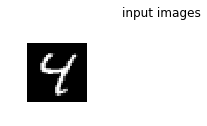

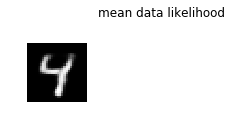

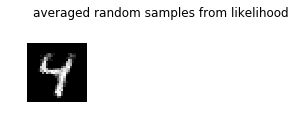

In [309]:
inim, res, s = sess.run([x_corr,naive_mean,naive_sims], feed_dict={x_corr: np.expand_dims(x_truth,-1)})
figure(figsize=(5,5))

    
figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(res[i,:,:,0],cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('averaged random samples from likelihood')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.mean(s[:,i,:,:,0],axis=0),cmap='gray',vmin=0); #colorbar()
    axis('off')

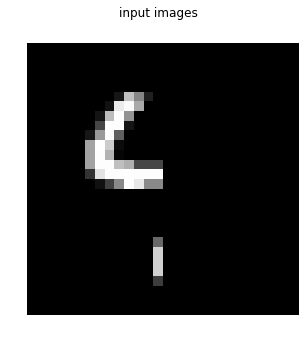

In [310]:
mask = np.ones(IMAGE_SHAPE, dtype=int)
mask[0:28,14:28]=0.
mask = mask.reshape((28*28))

masked_data = np.expand_dims(x_test[inc:batch_size+inc]*[mask],-1)

figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size,16)):
    if batch_size<16:
      subplot(1,batch_size,i+1)
      imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')
    else:
      subplot(4,4,i+1)
      imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
      axis('off')

<Figure size 360x360 with 0 Axes>

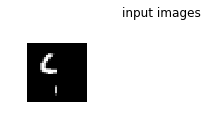

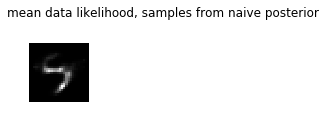

In [311]:
inim, res = sess.run([x_corr,naive_mean],feed_dict={x_corr: masked_data, mymask:mask})


figure(figsize=(5,5))

    
figure(figsize=(5,5))
suptitle('input images')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('mean data likelihood, samples from naive posterior')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(res[i,:,:,0],cmap='gray',vmin=0); #colorbar()
    axis('off')



In [345]:
posterior2_loss=[]
ini = np.zeros((batch_size,hidden_size), dtype=np.float)
sess.run(MAP_reset,feed_dict={x_corr: masked_data, mymask: mask, MAP_ini:ini})

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [346]:
lrate=1e-1
for ii in range(300):
  _, ll = sess.run([opt_op2,loss],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  posterior2_loss.append(ll)
  if ii%100==0:
    print(ll)
lrate=1e-3
for ii in range(800):
  _, ll = sess.run([opt_op2,loss],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  posterior2_loss.append(ll)
  if ii%100==0:
    print(ll)
lrate=1e-5
for ii in range(800):
  _, ll = sess.run([opt_op2,loss],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  posterior2_loss.append(ll)
  if ii%100==0:
    print(ll)

158.44145
43.901257
43.899086
43.899086
43.899086
43.899086
43.899086
43.899086
43.899086
43.899086
43.899086
43.899086
43.899086
43.899086
43.899086
43.899086
43.899086
43.899086
43.899086


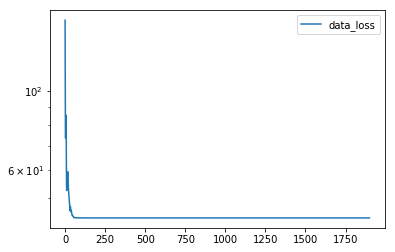

In [347]:
plot(posterior2_loss,label='data_loss')
legend()
yscale('log')

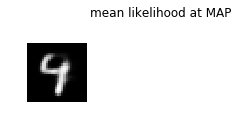

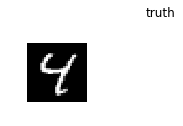

In [348]:
xrecons= sess.run(MAP_mean, feed_dict={x_corr: masked_data, mymask: mask})
xrecons.shape
    

figure(figsize=(5,5))
suptitle('mean likelihood at MAP')
for i in range(min(batch_size,16)):
#     if batch_size<16:
#       subplot(1,batch_size,i+1)
#       imshow(xrecons[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
#       axis('off')
#     else:
    subplot(4,4,i+1)
    imshow(xrecons[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
      
figure(figsize=(5,5))
suptitle('truth')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(x_truth[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:
_=sess.run(update2,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})

In [0]:
_=sess.run(update3,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})

(64, 1, 784)


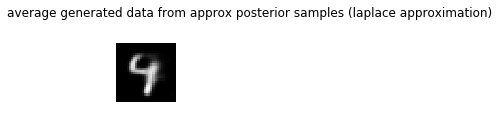

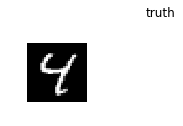

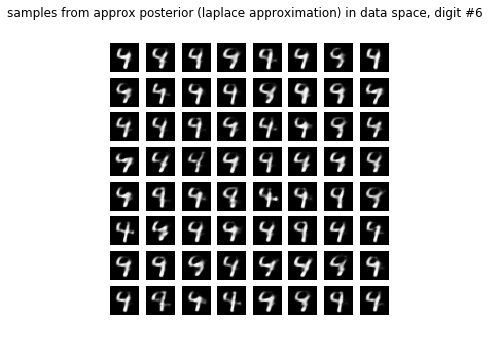

In [354]:
xrecons3 = sess.run(new_x_mean, feed_dict={x_corr: masked_data, sample_size_z:64 , mymask: mask})
print(xrecons3.shape)
# xrecons4 = sess.run(var_mean, feed_dict={x_corr: masked_data, sample_size:64, mymask: mask})
# print(xrecons3.shape)

figure(figsize=(5,5))
suptitle('average generated data from approx posterior samples (laplace approximation)')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(np.mean(xrecons3[:,i,:],axis=(0)).reshape((28,28)),cmap='gray',vmin=0); 
    axis('off')
      
figure(figsize=(5,5))
suptitle('truth')
for i in range(min(batch_size,16)):
    subplot(4,4,i+1)
    imshow(x_truth[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('samples from approx posterior (laplace approximation) in data space, digit #%d'%num)
for jj in range(64):   
  subplot(8,8,jj+1)
  imshow(xrecons3[jj,0].reshape((28,28)),cmap='gray',vmin=0); 
  axis('off')
  


      
# figure(figsize=(5,5))
# suptitle('mean likelihood at stddev')
# for i in range(min(batch_size,16)):
#     if batch_size<16:
#       subplot(1,batch_size,i+1)
#       imshow(xrecons4[i].reshape((28,28)),cmap='gray',vmin=0);
#       axis('off')
#     else:
#       subplot(4,4,i+1)
#       imshow(xrecons4[i].reshape((28,28)),cmap='gray',vmin=0);
#       axis('off')
      

In [315]:
minima=[]
min_loss=[]
n_samples=100
for jj in range(n_samples):
  print(jj)
  ini = np.random.random((batch_size,hidden_size))*50-25.
  print(ini)
  sess.run(MAP_reset,feed_dict={x_corr: masked_data, mymask: mask, MAP_ini:ini})
  for lrate,num in zip([1e-1,1e-2, 1e-3, 1e-5],[300,400,1000,1000]):
    for ii in range(num):
      _, ll = sess.run([opt_op2,loss],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  minima+=[sess.run(MAP,feed_dict={x_corr: masked_data, mymask: mask, MAP_ini:ini})]
  min_loss+=[ll]

0
[[-16.03418393  -3.0365464  -23.35553264   9.13528334 -22.43687467
   -0.89834628  19.86148079   7.70463156 -10.13928808  12.8415137 ]]
1
[[  2.26472411  -4.79599147 -23.53237728  -0.38581427  11.18649102
    0.35913832  17.94355067 -16.85087002   9.33283924   9.61952355]]
2
[[ 21.41575997   1.3718005    8.75916688  15.81983589  22.12345545
    2.68980611 -11.56869084 -13.4765088   23.24040736 -20.95994645]]
3
[[-21.8563063  -13.34296559 -18.62647841  11.20215018 -12.19892479
    0.4335456    7.63388531   7.18003056   6.45826781 -22.3520201 ]]
4
[[ -3.24959968 -19.27280868 -12.92067706  -4.50199127  -8.59584633
  -20.72320717 -15.35874295 -15.77926736   0.3755479   17.28489484]]
5
[[-14.65795858 -11.59506373 -24.55861413 -23.21207952  12.4798098
    2.91373132 -23.44013777  14.21409705 -13.56478206  -5.96284981]]
6
[[-16.92601612 -12.47664424  22.13570021  21.71051722  12.80204949
   14.94574914 -14.27016642   4.59303675  19.86819823 -23.6100554 ]]
7
[[ -9.71107481 -17.03482829 -20.5

Text(0, 0.5, 'loss')

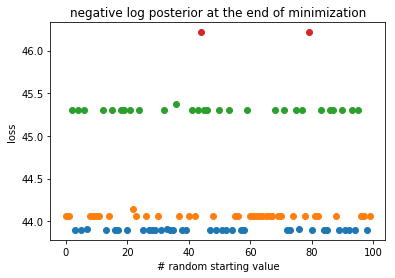

In [357]:
min_loss = np.asarray(min_loss)
index1 = np.where(min_loss<43.95)
index3 = np.where((min_loss>45)*(min_loss<46))
index4 = np.where(min_loss>46)
index2 = np.where((min_loss>43.95)*(min_loss<45))
x = np.arange(n_samples)
plt.figure()
plt.title('negative log posterior at the end of minimization')
plt.plot(x[index1],min_loss[index1], ls='', marker='o')
plt.plot(x[index2],min_loss[index2], ls='', marker='o')
plt.plot(x[index3],min_loss[index3], ls='', marker='o')
plt.plot(x[index4],min_loss[index4], ls='', marker='o')
#plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# random starting value')
plt.ylabel('loss')

W0424 21:20:40.607518 140198046865280 legend.py:1289] No handles with labels found to put in legend.


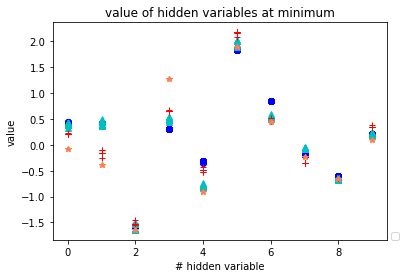

In [358]:
minima = np.asarray(minima)
plt.figure()
plt.title('value of hidden variables at minimum')
for index, color, m in zip([index1, index2, index3, index4],['b','c','r','coral'], ['o','^','+','*']):
  for ii in index[0]:
    plt.plot(np.arange(hidden_size),minima[ii,0,:], ls='', marker=m, color=color)
plt.legend(ncol=4, loc=(1.01,0))
plt.xlabel('# hidden variable')
plt.ylabel('value')
plt.show()

assuming there are four distinct minima in this case

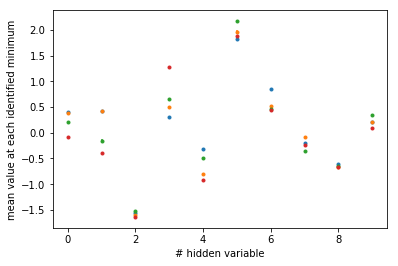

In [359]:
mus = []
std_mus = []
for index in [index1, index2, index3, index4]:
  mus+=[np.mean(minima[index], axis=0)]
  std_mus+=[np.std(minima[index], axis=0)]

mus    =np.asarray(mus)
std_mus=np.asarray(std_mus)
plt.figure()
for ii in range(4):
  plt.errorbar(np.arange(10),mus[ii][0], yerr=std_mus[ii][0], ls='', marker='.')
plt.xlabel('# hidden variable')
plt.ylabel('mean value at each identified minimum')
plt.show()

get covariances at these three minima to build Gaussian mixture model

In [360]:
mu_=[]
sigma_=[]
for ii in range(num_comp):
  print(sess.run(MAP_reset,feed_dict={x_corr: masked_data, mymask: mask, MAP_ini:mus[ii]}))
  mu_+=[sess.run(update2,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})]
  sigma_+=[sess.run(update3,feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})]
mu_    = np.asarray(mu_)
sigma_ = np.asarray(sigma_)

[[ 0.4066869   0.41663104 -1.5680795   0.30190706 -0.31247395  1.8305696
   0.8510054  -0.19392285 -0.6123942   0.20210887]]
[[ 0.39353412  0.41698    -1.6015519   0.49801722 -0.80228513  1.9639866
   0.5304165  -0.07222392 -0.65915525  0.20229813]]
[[ 0.21580945 -0.1532637  -1.5300335   0.6591806  -0.48208025  2.1738892
   0.4687861  -0.359751   -0.636684    0.3526401 ]]
[[-0.0857738  -0.39543882 -1.643194    1.2808583  -0.9102899   1.8937888
   0.44074875 -0.23076358 -0.66793704  0.09915359]]


In [361]:
w=[]
#choosing weights from how often I land in this minimum?
for index in [index1, index2, index3, index4]:
  w+=[len(index[0])/n_samples]
w=np.asarray(w)
print(sum(w),w)


1.0 [0.35 0.35 0.28 0.02]


In [0]:
sigma_=sigma_.reshape(1,4,10,10)
mu_=mu_.reshape(1,4,10)

In [0]:
_= sess.run(gmm_sample_x,feed_dict={x_corr: masked_data, mymask: mask, mu_est: mu_, sigma_est: sigma_, w_est:w })
_= sess.run(update_a,feed_dict={x_corr: masked_data, mymask: mask, mu_est: mu_, sigma_est: sigma_, w_est:w })
_=sess.run(update_b,feed_dict={x_corr: masked_data, mymask: mask, mu_est: mu_, sigma_est: sigma_, w_est:w })
_=sess.run(update_c,feed_dict={x_corr: masked_data, mymask: mask, mu_est: mu_, sigma_est: sigma_, w_est:w })

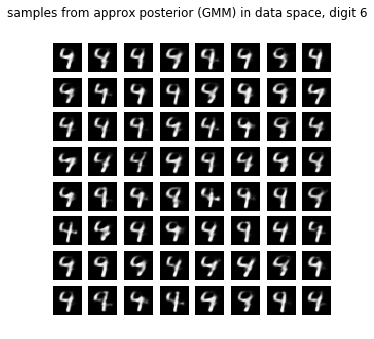

In [364]:
x_recons = sess.run(gmm_sample_x,feed_dict={x_corr: masked_data, sample_size_z:64 , mymask: mask})

num = 6
figure(figsize=(5,5))
suptitle('samples from approx posterior (GMM) in data space, digit %d'%num)
for jj in range(64):   
  subplot(8,8,jj+1)
  imshow(xrecons3[jj,0,:].reshape((28,28)),cmap='gray',vmin=0); 
  axis('off')

In [0]:
posterior3_loss=[]

In [0]:
lrate=1e-2
for ii in range(2000):
  _, ll = sess.run([opt_op_elbo2, elbo2],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  posterior3_loss.append(ll)
  if ii%100==0:
    print(ll)
lrate=1e-4
for ii in range(1000):
  _, ll = sess.run([opt_op_elbo2, elbo2],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  posterior3_loss.append(ll)
  if ii%100==0:
    print(ll)
lrate=1e-8
for ii in range(1000):
  _, ll = sess.run([opt_op_elbo2, elbo2],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})
  posterior3_loss.append(ll)
  if ii%100==0:
    print(ll)

51.133766
50.43215
49.607887
49.728355
48.844955
50.44349
48.81931
49.312874
49.397713
49.82924
49.099586
49.868675
49.052254
49.49446
49.32017
49.386066
48.76383
49.11968
48.974174
49.377495
49.165127
49.233414
49.59709
48.915657
48.71952
49.118095
49.44622
49.144897
48.88849
48.85293
48.408142
49.402134
48.610107
49.07057
48.926132
49.004032
48.863136
49.37509
48.622906
50.092194
49.479275
49.622
48.684418
48.589813
49.42263
49.906113
48.9205
48.925194
48.575947
48.741383
48.722683
48.77562
48.96171
48.952366
48.823624
48.541485
48.535034
48.687397
49.0568
48.93477


In [0]:
sess.run([tf.reduce_mean(posterior_corr_elbo)],feed_dict={x_corr: masked_data, lr:lrate, mymask:mask})

[-48.11485]

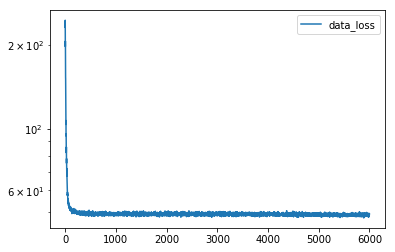

In [0]:
plot(posterior3_loss,label='data_loss')
legend()
yscale('log')

(64, 64, 784)


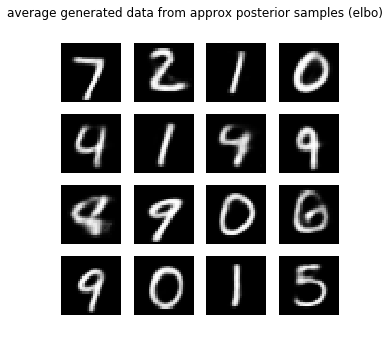

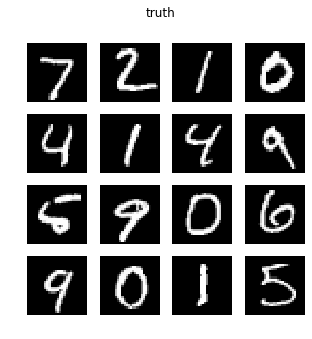

In [0]:
xrecons3 = sess.run(x_mean_elbo, feed_dict={x_corr: masked_data, sample_size_z:64 , mymask: mask})
print(xrecons3.shape)
# xrecons4 = sess.run(var_mean, feed_dict={x_corr: masked_data, sample_size:64, mymask: mask})
# print(xrecons3.shape)

figure(figsize=(5,5))
suptitle('average generated data from approx posterior samples (elbo)')
for i in range(min(batch_size,16)):
    if batch_size<16:
      subplot(1,batch_size,i+1)
      imshow(np.mean(xrecons3[:,i,:],axis=(0)).reshape((28,28)),cmap='gray',vmin=0); 
      axis('off')
    else:
      subplot(4,4,i+1)
      imshow(np.mean(xrecons3[:,i,:],axis=(0)).reshape((28,28)),cmap='gray',vmin=0); 
      axis('off')
      
figure(figsize=(5,5))
suptitle('truth')
for i in range(16):
    subplot(4,4,i+1)
    imshow(x_truth[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')